In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string

#NLP
import gensim
import spacy
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop = stopwords.words('english')
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, int(float(value)), ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, int(float(value)), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)       
        
def remove_double_space(text):
    return " ".join(text.split())

def remove_punctuation(text):
    if type(text)==float:
        return text
    ans = ""
    for i in text:
        if i not in string.punctuation:
            ans += i
    return ans

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)


## Data cleaning

In [3]:
### Read & clean data from csv

# Tweets sheet
df_tweet = pd.read_excel(r"C:\Users\hhajj\Python codes\Topic_Modelling\Twitter_data.xlsx", "Tweet")
df_tweet.drop(df_tweet.tail(1).index,inplace=True)
df_tweet.columns = ['TweetID','Weekday','Hour','Day','Lang','IsReshare','Reach','RetweetCount','Likes','Klout','Sentiment','text','LocationID','UserID']

# Location sheet
df_location = pd.read_excel(r"C:\Users\hhajj\Python codes\Topic_Modelling\Twitter_data.xlsx", "Location")
df_location.drop(df_location.tail(2).index,inplace=True)

# User sheet
df_user = pd.read_excel(r"C:\Users\hhajj\Python codes\Topic_Modelling\Twitter_data.xlsx", "User")
df_user.drop(df_user.tail(1).index,inplace=True)

In [4]:
df = df_tweet.merge(df_location, on='LocationID').merge(df_user, on='UserID')
df.head(3)

,TweetID,Weekday,Hour,Day,Lang,IsReshare,Reach,RetweetCount,Likes,Klout,Sentiment,text,LocationID,UserID,Country,State,StateCode,City,Gender
0,tw-682712873332805633,Thursday,17.0,31.0,en,0.0,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Prot...,3751.0,tw-40932430,United States,Washington,US-WA,Seattle,Female
1,tw-682763193471643648,Thursday,20.0,31.0,en,0.0,45.0,0.0,0.0,36.0,0.0,We are hiring: Software Developer Engineer So ...,3751.0,tw-40932430,United States,Washington,US-WA,Seattle,Female
2,tw-682813530475773952,Thursday,23.0,31.0,en,0.0,45.0,0.0,0.0,36.0,0.0,We are hiring: Software Development Engineer h...,3751.0,tw-40932430,United States,Washington,US-WA,Seattle,Female


In [5]:
df.isna().sum()

TweetID            0
Weekday            0
Hour               0
Day                0
Lang               0
IsReshare          0
Reach              0
RetweetCount       0
Likes              0
Klout              0
Sentiment          0
text               4
LocationID         0
UserID             0
Country            0
State           1897
StateCode       1726
City            2279
Gender             0
dtype: int64

In [6]:
df.columns

Index(['TweetID', 'Weekday', 'Hour', 'Day', 'Lang', 'IsReshare', 'Reach',
       'RetweetCount', 'Likes', 'Klout', 'Sentiment', 'text', 'LocationID',
       'UserID', 'Country', 'State', 'StateCode', 'City', 'Gender'],
      dtype='object')

In [7]:
# selecting important columns for the analysis

data = df[['text','Reach','RetweetCount','RetweetCount','Likes','Klout','Weekday','Country','Gender']]

In [8]:
# removing all missing values from the dataset
data = data.dropna()

## NLP : Text cleaning

In [9]:
# Data claning for NLP
data["text"] = data["text"].apply(lambda x: remove_punctuation(x)).str.lower() # remove punctuation   
data["text"] = data["text"].apply(lambda x: remove_emoji(x)) # remove emoji    
data["text"] = data["text"].apply(lambda x: remove_double_space(x)) # remove double space

In [10]:
#Puting the text data in a list
text = data['text'].values.tolist()

In [11]:
# Remove Emails
text = [re.sub(r'\S*@\S*\s?', '', sent) for sent in text]
# Remove new line characters
text = [re.sub(r'\s+', ' ', sent) for sent in text]
# Remove distracting single quotes
text = [re.sub(r"\'", "", sent) for sent in text]
# Remove urls
text = [re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', sent) for sent in text]

## Tokenization

In [12]:
def sent_to_words(sentences):
    """This function Tokenize sentences using Gensim

    Parameters
    ----------
    sentences : str
        the sentences that will be tokenized
        
    Returns
    -------
    list
        a list of tokenized words
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [13]:
data_words = list(sent_to_words(text))
print(data_words[:1])

[['we', 'are', 'hiring', 'senior', 'software', 'engineer', 'proto', 'lapxxufwczs', 'zurjkrgcidmqtro', 'job', 'awscloud', 'job', 'protocol', 'networking', 'aws', 'mediastreaming']]


## Lemmatization & Model building

In [14]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    """This function performs stemmining on sentences

    Parameters
    ----------
    text : str
        the sentences that will be stemmed
    allowed_postags (Optional) : list
        postags to be used for stemming
        
    Returns
    -------
    str
        stemmed sentences
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [15]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_lg')

nlp.disable_pipes('ner', 'parser')

# lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['hire software engineer job protocol networking', 'hire software developer engineer kyc job workspace']


## Build LDA model

In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, # minimum read occurences of a word 
                             stop_words='english',  # remove stop words
                             lowercase=True,    # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3    
                            )

In [17]:
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [18]:
# Build LDA Model
lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
                          n_components=5, n_jobs=-1, perp_tol=0.1,
                          random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0
                         )

In [19]:
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Returns Model attributes

LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          n_components=5, n_jobs=-1, random_state=100)


## Model evaluation

In [20]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2912784.821333808
Perplexity:  748.9497213292447
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [21]:
# Best Model
best_lda_model = lda_model


## Dominant Topic

In [22]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [23]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [24]:
# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.030000,0.030000,0.030000,0.030000,0.890000,4
Doc1,0.030000,0.310000,0.030000,0.030000,0.600000,4
Doc2,0.040000,0.040000,0.040000,0.040000,0.840000,4
Doc3,0.050000,0.050000,0.050000,0.050000,0.800000,4
Doc4,0.070000,0.070000,0.070000,0.070000,0.730000,4
Doc5,0.050000,0.050000,0.050000,0.050000,0.800000,4
Doc6,0.050000,0.050000,0.050000,0.300000,0.550000,4
Doc7,0.040000,0.640000,0.040000,0.040000,0.240000,1
Doc8,0.040000,0.240000,0.040000,0.040000,0.640000,4
Doc9,0.030000,0.030000,0.530000,0.030000,0.400000,2


In [25]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaction,aapl,abandon,ability,ablq,abstraction,abuse,accelerate,accelerator,...,yesterday,yfn,yhygg,ytctu,zeppelin,zgvkmme,zip,zombie,zone,zovvr
Topic0,0.269880,14.331461,0.203494,0.201255,25.472131,0.201511,20.825116,0.201518,117.286590,0.201754,...,0.202264,0.202823,0.202568,0.201496,4.386369,0.297667,0.295448,366.215497,164.888991,17.719775
Topic1,0.200820,1.817577,0.208048,0.202493,13.068879,0.200026,0.290377,0.204698,0.205192,0.200723,...,91.117569,12.711496,17.299524,0.200016,25.897849,21.073807,10.283876,0.202653,0.202031,0.200026
Topic2,0.200051,0.622405,37.298527,0.203617,0.201435,16.822945,0.202667,0.209375,0.200813,0.200858,...,0.201801,0.200016,0.200014,0.200016,0.200024,6.883359,0.202085,0.202245,0.201316,0.200029
Topic3,0.200126,0.207561,0.210083,187.113901,0.205864,0.201162,0.202875,18.929352,0.212066,0.200284,...,0.201573,0.202059,0.200010,10.008366,0.200017,7.029537,0.201512,543.569459,0.202902,0.200020
Topic4,58.821457,6.041518,0.204997,0.202969,0.202311,0.200031,0.201336,0.201563,0.212299,50.228457,...,0.200192,0.200017,0.200015,0.200018,0.200026,0.216515,0.200038,0.200503,0.201246,0.200033


In [26]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    """This function shows the top n keywords on each topic

    Parameters
    ----------
    vectorizer : matrix
        document-word matrix
    lda_model : model
         The Latent Dirichlet Allocation (LDA) model built
        
    Returns
    -------
    str
        keywords on each topic
    """
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [27]:
#Get the topic keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)

In [28]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,photo,cloud,use,adbid,lambda,blog,learn,aws,support,instance
Topic 1,year,developer,run,azure,say,launch,migration,application,week,migrate
Topic 2,security,make,certificate,manager,know,performance,computing,storage,infrastructure,product
Topic 3,service,web,announce,work,apple,customer,business,database,region,amazon
Topic 4,job,engineer,hire,devop,software,enterprise,datum,manager,game,development


In [29]:
# Naming the topics manually based on words

Topics = df_topic_keywords.index
Topics = ["Cloud computing",
          "Developer toolkit",
          "IT security",
          "Business",
          "Hiring & job offers"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Topics
Topic 0,photo,cloud,use,adbid,lambda,blog,learn,aws,support,instance,Cloud computing
Topic 1,year,developer,run,azure,say,launch,migration,application,week,migrate,Developer toolkit
Topic 2,security,make,certificate,manager,know,performance,computing,storage,infrastructure,product,IT security
Topic 3,service,web,announce,work,apple,customer,business,database,region,amazon,Business
Topic 4,job,engineer,hire,devop,software,enterprise,datum,manager,game,development,Hiring & job offers


In [30]:
# Define function to predict topic for a given text document.
nlpPred = spacy.load('en_core_web_lg')
nlpPred.disable_pipes('ner', 'parser')

def predict_topic(text, nlp=nlpPred):
    global sent_to_words
    global lemmatization
    
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
    
    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
    
    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores

# Predict the topic
mytext = ["Amazon is hiring for the AWS team a project manager"] # Example
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['engineer', 'hire', 'devop', 'software', 'enterprise', 'datum', 'manager', 'game', 'development', 'Hiring & job offers']
Hiring & job offers


In [31]:
def apply_predict_topic(text):
    text = [text]
    infer_topic, topic, prob_scores = predict_topic(text = text)
    return(infer_topic)

data["Topic"]= data['text'].apply(apply_predict_topic) # Predict topics for all the dataframe
data.head(5)

,text,Reach,RetweetCount,RetweetCount,Likes,Klout,Weekday,Country,Gender,Topic
0,we are hiring senior software engineer proto h...,44.0,0.0,0.0,0.0,35.0,Thursday,United States,Female,Hiring & job offers
1,we are hiring software developer engineer so h...,45.0,0.0,0.0,0.0,36.0,Thursday,United States,Female,Hiring & job offers
2,we are hiring software development engineer ht...,45.0,0.0,0.0,0.0,36.0,Thursday,United States,Female,Hiring & job offers
3,we are hiring senior software engineer win htt...,45.0,0.0,0.0,0.0,36.0,Friday,United States,Female,Hiring & job offers
4,we are hiring system engineer ms exchange http...,45.0,0.0,0.0,0.0,36.0,Friday,United States,Female,Hiring & job offers


## Days post were made

In [32]:
def days_of_post(data):
    ax= pd.crosstab(data['Topic'], data['Weekday']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(20,10),stacked=True, rot=0)
    display(ax)

    plt.legend(loc='upper left', bbox_to_anchor=(1,1.025), title="Day of the Week")
    plt.xlabel('Name')
    plt.title('Distribusion of Days of the week posts were made')
    plt.ylabel('Percent Distribution')

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.0f}%".format(height),
                  ha='center', 
                  va='bottom')

    return plt.show()

Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Topic,,,,,,,
Business,13.622926,15.559578,6.316742,5.840121,16.772247,20.108597,21.779789
Cloud computing,14.941819,15.211210,7.383919,6.706701,19.021963,18.354099,18.380290
Developer toolkit,13.740525,17.905376,6.822340,6.081729,19.944236,19.090355,16.415440
Hiring & job offers,14.736035,14.304877,10.338220,10.961004,16.010348,18.060745,15.588771
IT security,18.902620,14.710826,7.701434,7.800297,18.882847,15.867523,16.134454


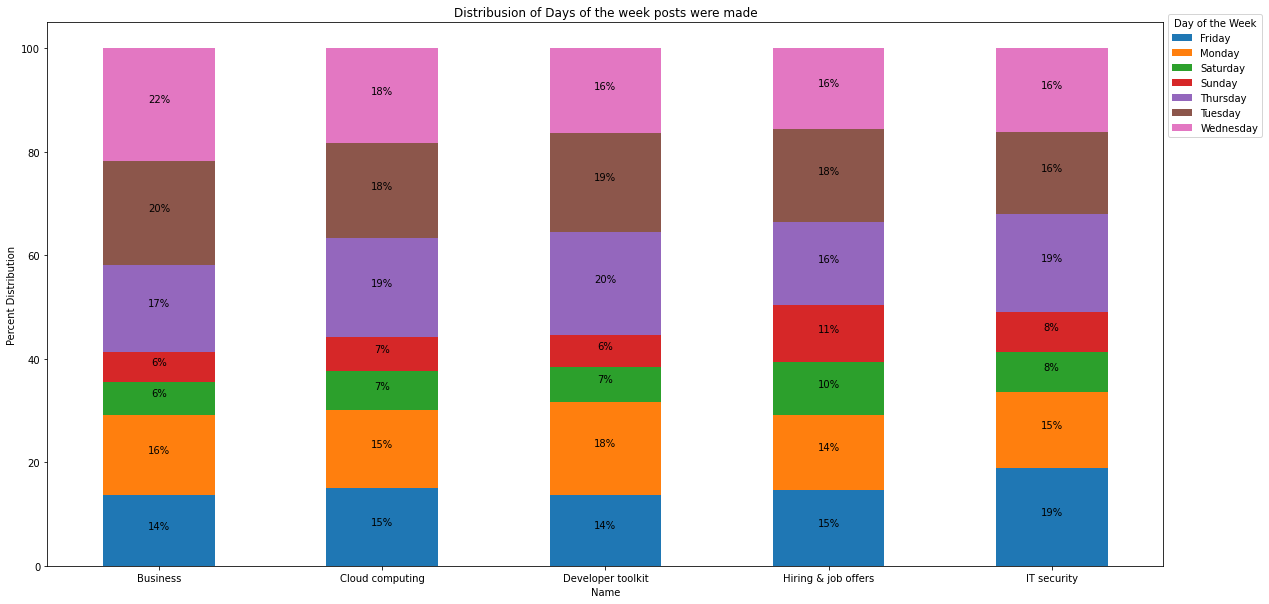

In [33]:
days_of_post(data)

## Gender of who posted

In [34]:
def gender_posts(data):
    ax= pd.crosstab(data['Topic'], data['Gender']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(20,10),stacked=True, rot=0)
    display(ax)

    plt.legend(loc='upper left', bbox_to_anchor=(1,1.025), title="Day of the Week")
    plt.xlabel('Name')
    plt.title('Distribusion of Days of the week posts were made')
    plt.ylabel('Percent Distribution')

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.0f}%".format(height),
                  ha='center', 
                  va='bottom')

    return plt.show()

Gender,Female,Male,Unisex,Unknown
Topic,,,,
Business,9.067873,50.956259,9.568627,30.407240
Cloud computing,8.850601,54.231676,7.724399,29.193325
Developer toolkit,10.020040,55.781127,9.322994,24.875839
Hiring & job offers,17.782888,32.576411,15.981604,33.659097
IT security,8.353930,53.040040,9.055858,29.550173


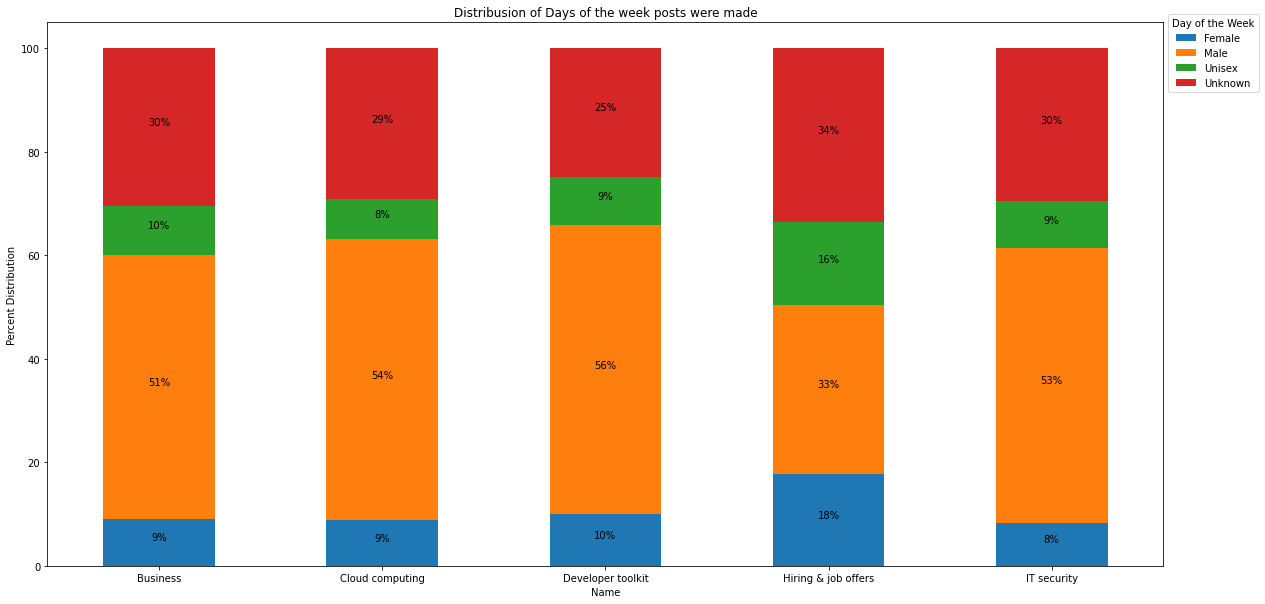

In [35]:
gender_posts(data)